In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [ ]:
def before_after_graph(befores, afters, ax, ylim=[-0.5, 35]):
    # plotting the points
    ax.scatter(np.zeros(len(befores)), befores, s=1, color='k')
    ax.scatter(np.ones(len(afters)), afters, s=1, color='k')
    # plotting the lines
    for i in range(len(befores)):
        ax.plot( [0,1], [befores[i], afters[i]], alpha=0.2, color='k')
    # hide the frame
    sns.despine(top=True, right=True, left=True)
    # ax.set_xticks([0.25, 0.75], ['gc', 'gc_K21'])
    ax.set_xticks([])
    # find max of befores and afters
    ax.set_ylim(ylim)


In [ ]:
wave1_wmh = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave1')
wave2_wmh = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave2')

# only keep the rows that `in_our_group_or_not` is 1
wave1_wmh = wave1_wmh[wave1_wmh['in_our_group_or_not'] == 1]
wave2_wmh = wave2_wmh[wave2_wmh['in_our_group_or_not'] == 1]

ids_wave1 = wave1_wmh['M_w1_ID']
ids_wave2 = wave2_wmh['M_w2_ID']
# Find the common IDs
common_ids = ids_wave1[ids_wave1.isin(ids_wave2)]

wave1_wmh = wave1_wmh[wave1_wmh['M_w1_ID'].isin(common_ids)]
wave2_wmh = wave2_wmh[wave2_wmh['M_w2_ID'].isin(common_ids)]

In [ ]:
groups = ["SNC", "NC", "MCI", "AD"]
figure = plt.figure(figsize=(5, 4), dpi=300)
ax1 = figure.add_subplot(1, 4, 1)
ax2 = figure.add_subplot(1, 4, 2)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax3 = figure.add_subplot(1, 4, 3)
ax3.set_yticklabels([])
ax3.set_yticks([])
ax4 = figure.add_subplot(1, 4, 4)
ax4.set_yticklabels([])
ax4.set_yticks([])
axs = [ax1, ax2, ax3, ax4]


for gg, ax in zip(groups, axs):
    group_data_before = np.array(wave1_wmh[wave1_wmh.M_w1_group == gg][wave1_wmh.columns[5]])
    group_data_after = np.array(wave2_wmh[wave2_wmh.M_w2_group == gg][wave2_wmh.columns[4]])
    before_after_graph(group_data_before, group_data_after, ax=ax, ylim=[-10, 60000])
    both_values = pd.concat([wave1_wmh.iloc[:,5][wave1_wmh.M_w1_group == gg], wave2_wmh.iloc[:,4][wave2_wmh.M_w2_group==gg]], axis=0)
    both_group = pd.concat([wave1_wmh.M_w1_group[wave1_wmh.M_w1_group == gg]+"_w1", wave2_wmh.M_w2_group[wave2_wmh.M_w2_group==gg]+"_w2"], axis=0)
    bp = sns.boxplot(x=both_group, y=both_values, ax=ax, showmeans=True, width=0.5,  showfliers=False, meanprops = {"marker":"o", "markeredgecolor":"black", "markersize":"7"})
    annot = Annotator(ax, [
            ((gg+"_w1", gg+"_w2"))],
            x=both_group,
            y=both_values)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
    annot.apply_and_annotate()
    ax.set_ylabel("")
    ax.set_xlabel(gg)
    ax.set_xticklabels("")
    ax.set_xticks([])


In [ ]:
diff_w1_w2 = pd.DataFrame()

for gg in groups:

    # slope
    # diff = wave2_wmh.iloc[:,4][wave2_wmh.M_w2_group==gg].values - wave1_wmh.iloc[:,5][wave1_wmh.M_w1_group == gg].values 
    
    # rate of changes
    diff = np.abs(wave2_wmh.iloc[:,4][wave2_wmh.M_w2_group==gg].values - wave1_wmh.iloc[:,5][wave1_wmh.M_w1_group == gg].values)

    caseid = wave1_wmh.M_w1_ID[wave1_wmh.M_w1_group == gg]
    group = wave1_wmh.M_w1_group[wave1_wmh.M_w1_group == gg]
    diff_w1_w2 = pd.concat([diff_w1_w2, pd.DataFrame({'group':group, 'caseid':caseid, 'diff':diff})], axis=0)


plt.figure(figsize=(5, 4), dpi=300)
# sns.violinplot(x='group', y='diff', data=diff_w1_w2)
sns.stripplot(x='group', y='diff', data=diff_w1_w2, color='k', alpha=0.5)
sns.pointplot(x='group', y='diff', data=diff_w1_w2, join=False, meanprops = {"marker":"o", "markersize":"7"})

annot = Annotator(plt.gca(), [
                (("SNC"), ("NC")),(("SNC"), ("MCI")), (("SNC"), ("AD")), (("NC"), ("MCI")),(("NC"),("AD")), (("MCI"),("AD"))],
                x="group",
                y='diff',
                data = diff_w1_w2)
annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, comparisons_correction='BH')
# annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
annot.apply_and_annotate()


plt.ylabel('WMH volume difference (wave2 - wave1)')
plt.xlabel('Group')
plt.title('WMH difference between wave1 and wave2')
plt.show()

In [ ]:
import sys
sys.path.append('/Users/yilewang/workspaces/')
from tvbtools.tools.statools import bootstrap_test
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]

figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
for j, gg in enumerate(groups):
    ci, box = bootstrap_test(diff_w1_w2["diff"][diff_w1_w2.group == gg].to_numpy(), iteration=1000, visual=False)
    sns.kdeplot(x = box, linewidth=2, fill = colors[j], color=colors[j])
    # ax.set(ylim=(-2.2, 0.01))
    # hide top and right frame
    sns.despine(top=True, right=True)
    # ax.hlines(y=-0.3-0.5*j, xmin=ci[0], xmax=ci[1], linewidth=2, color = colors[j])
    # ax.vlines(x=ci[0], ymin=-0.3-0.5*j-0.2, ymax=-0.3-0.5*j+0.2, linewidth=2, color = colors[j])
    # ax.vlines(x=ci[1], ymin=-0.3-0.5*j-0.2, ymax=-0.3-0.5*j+0.2, linewidth=2, color = colors[j])

### Lateralization Index of ROI

In [13]:
wave1_wmh = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave1')
wave2_wmh = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave2')

# only keep the rows that `in_our_group_or_not` is 1
wave1_wmh = wave1_wmh[wave1_wmh['in_our_group_or_not'] == 1]
wave2_wmh = wave2_wmh[wave2_wmh['in_our_group_or_not'] == 1]

ids_wave1 = wave1_wmh['M_w1_ID']
ids_wave2 = wave2_wmh['M_w2_ID']
# Find the common IDs
common_ids = ids_wave1[ids_wave1.isin(ids_wave2)]

wave1_wmh = wave1_wmh[wave1_wmh['M_w1_ID'].isin(common_ids)]
wave2_wmh = wave2_wmh[wave2_wmh['M_w2_ID'].isin(common_ids)]

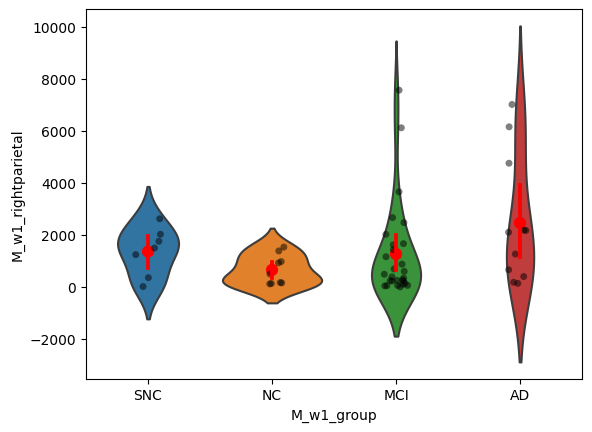

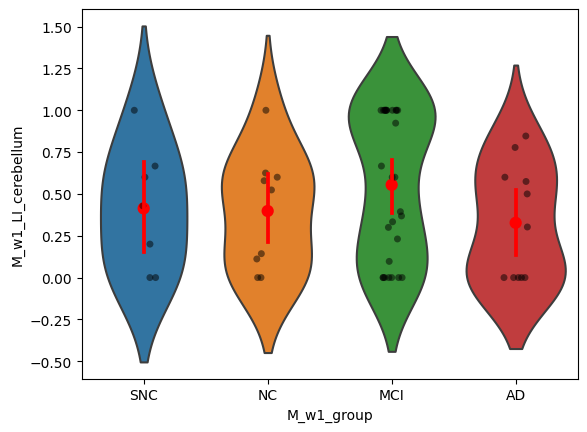

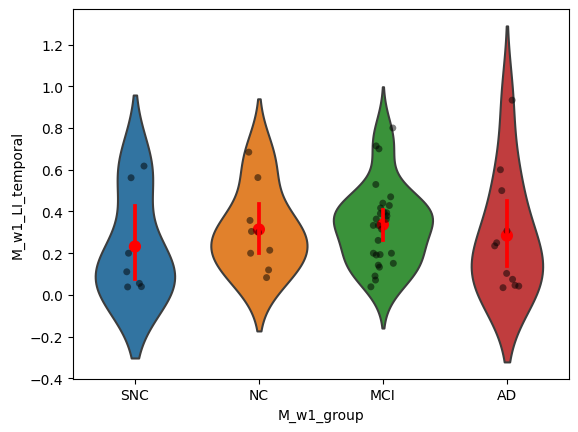

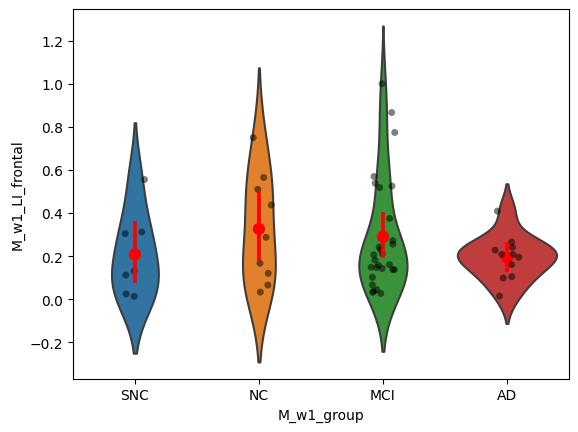

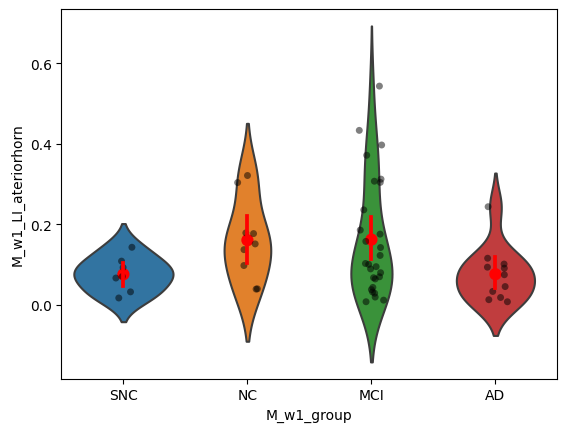

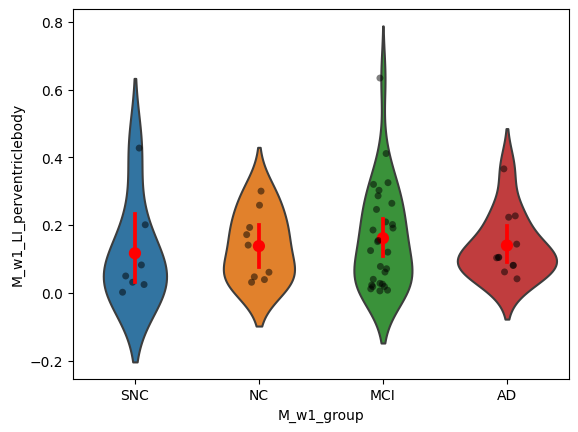

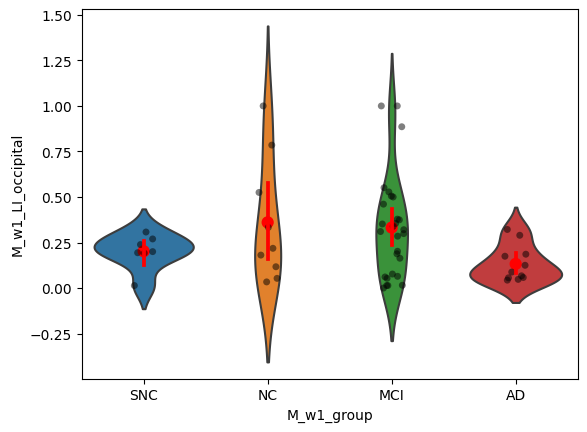

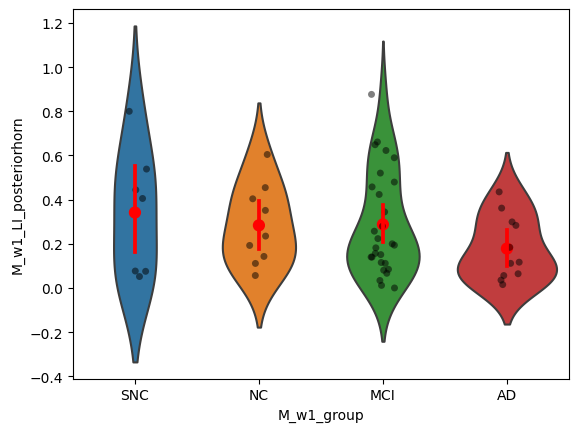

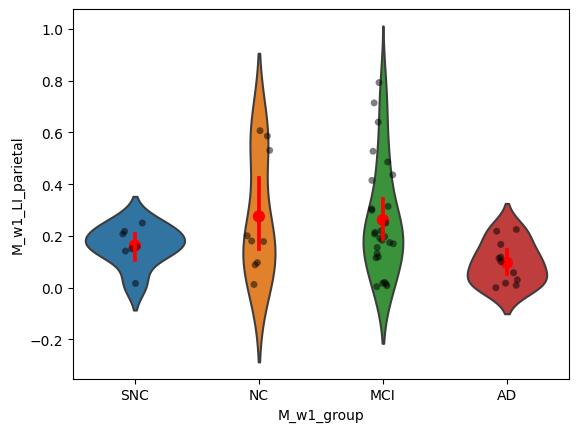

In [19]:
df = wave1_wmh
numeric_cols = df.iloc[:,6:]
df = pd.concat([df.iloc[:,:6], numeric_cols.abs()], axis=1)

# plot all the columns
order = ["SNC", "NC", "MCI", "AD"]
for i in range(23, len(df.columns)):
    figure = plt.figure()
    sns.violinplot(x="M_w1_group", y=df.columns[i], data=df, inner=None, order=order)
    sns.pointplot(x="M_w1_group", y=df.columns[i], data=df, palette=["red"], linestyles="-", order=order)
    sns.stripplot(x="M_w1_group", y=df.columns[i], data=df, color='black', alpha=0.5,zorder=1, order=order)
    plt.show()

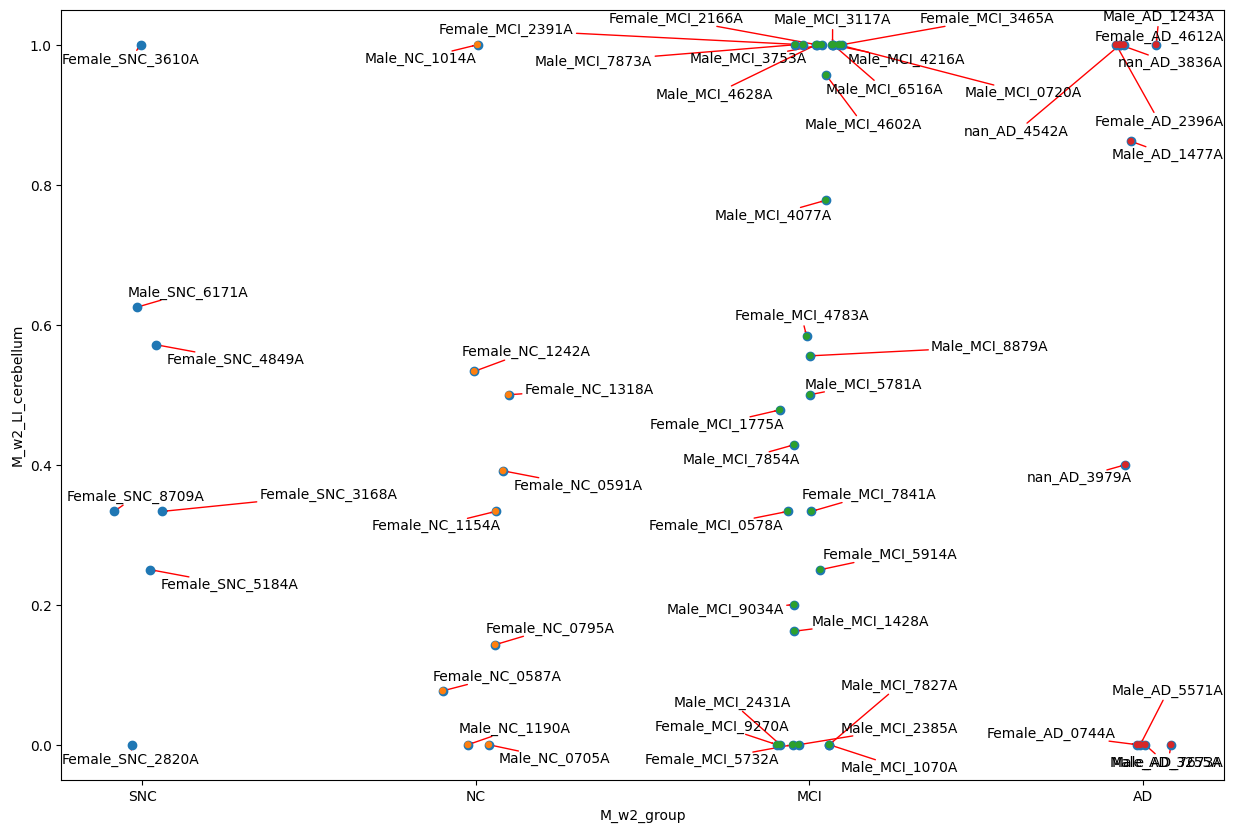

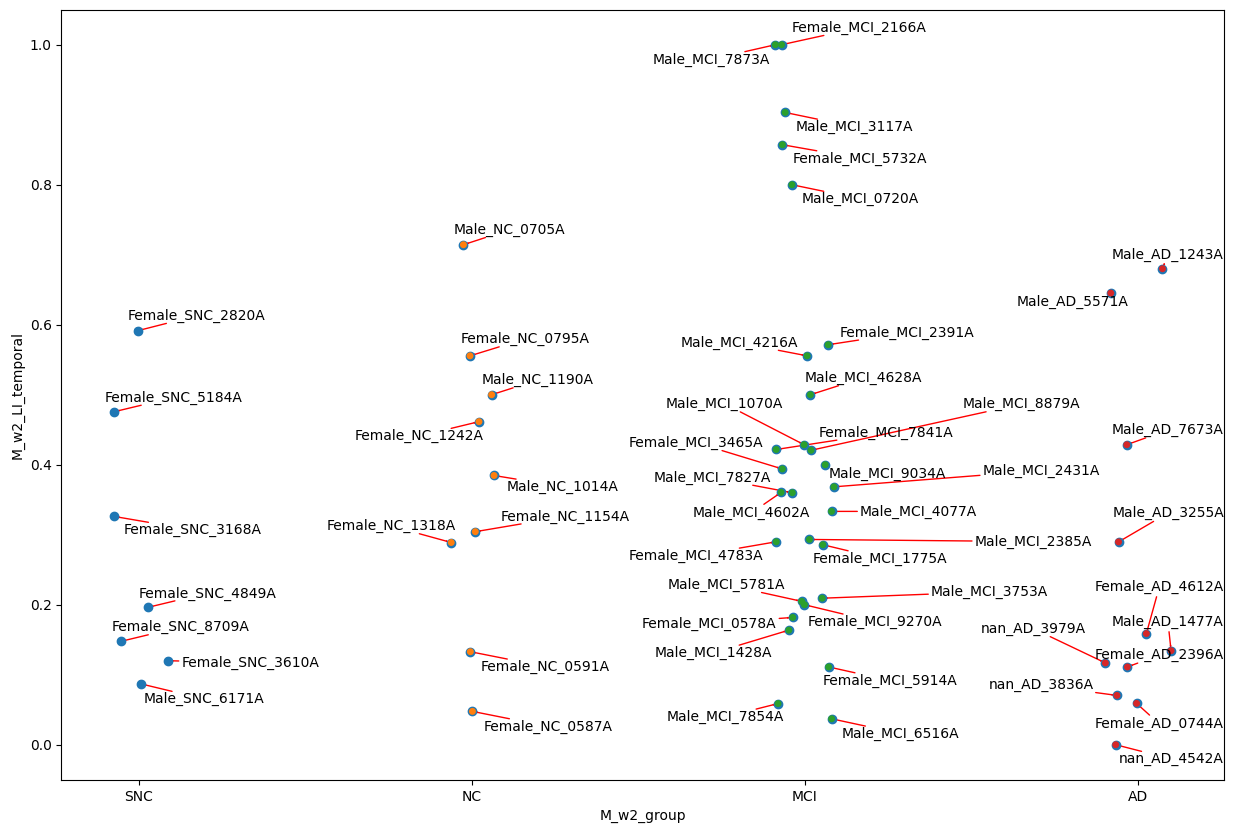

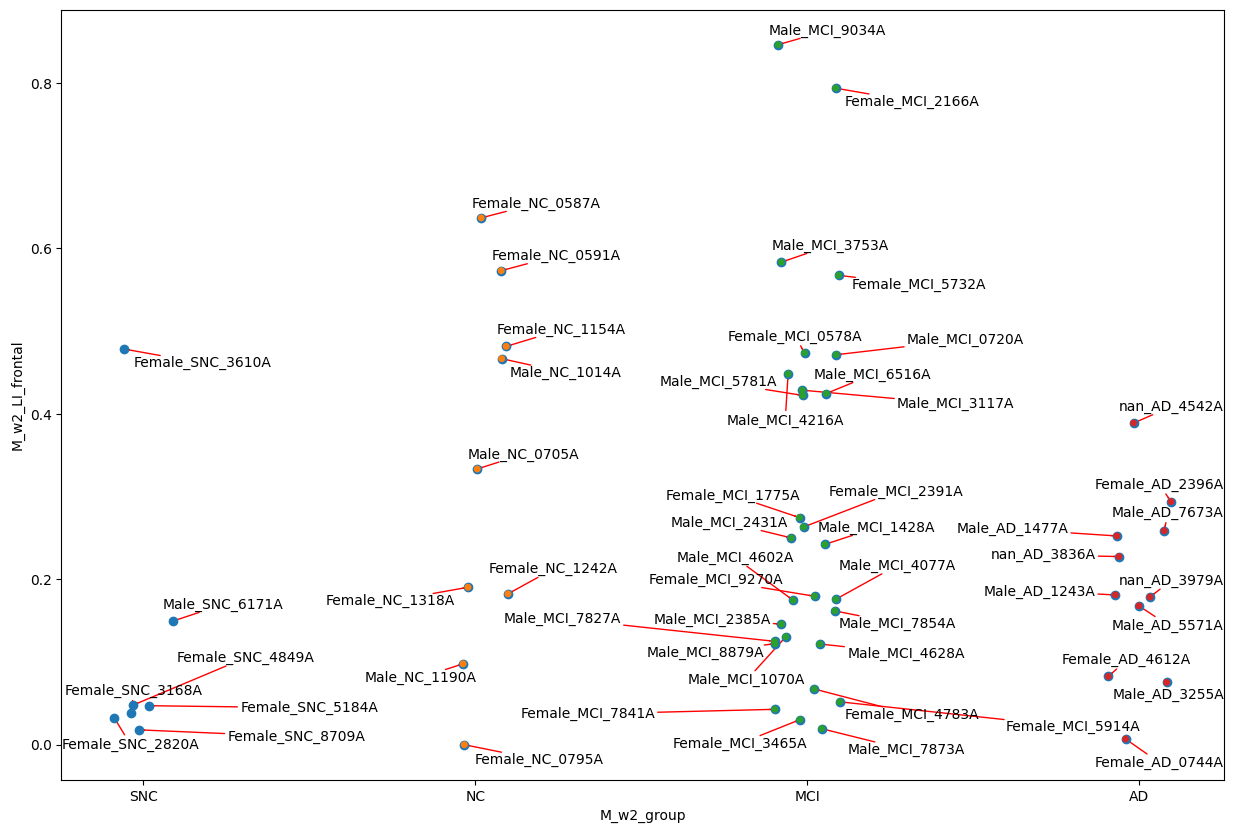

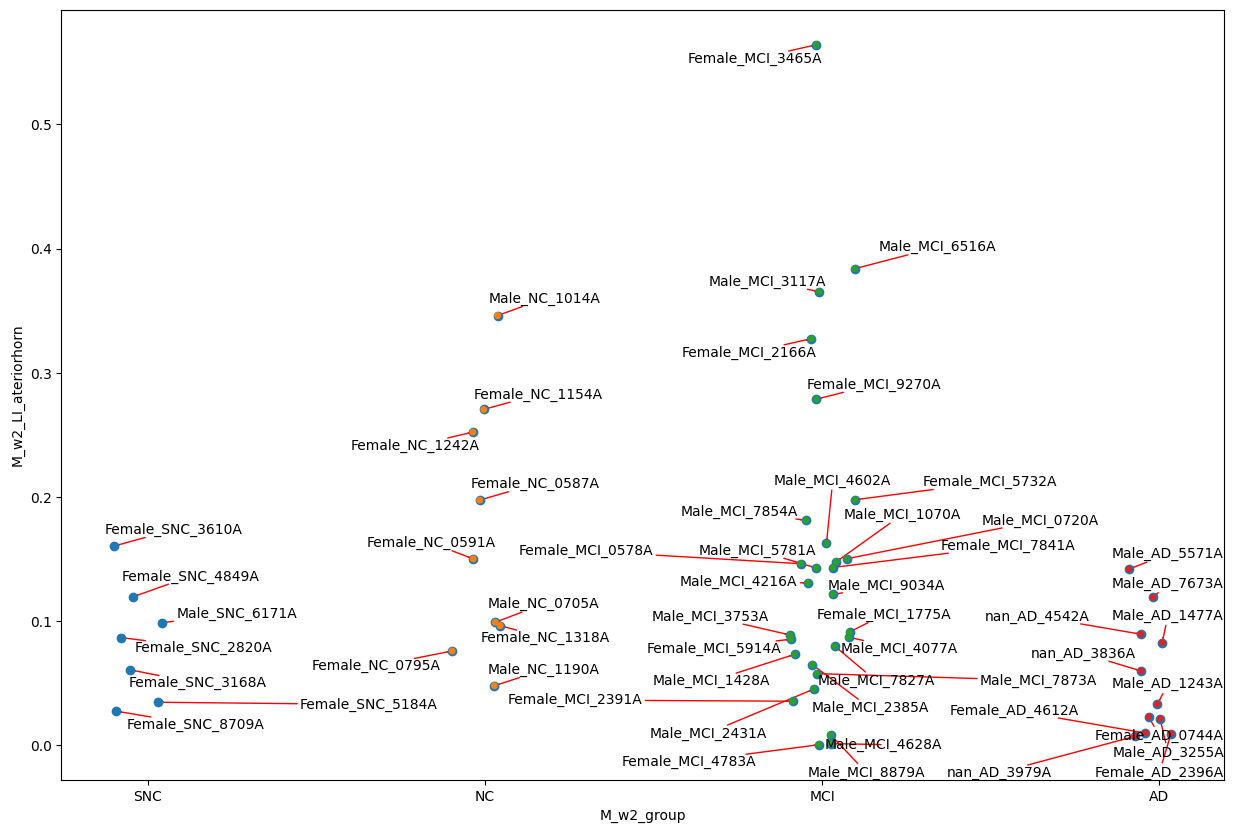

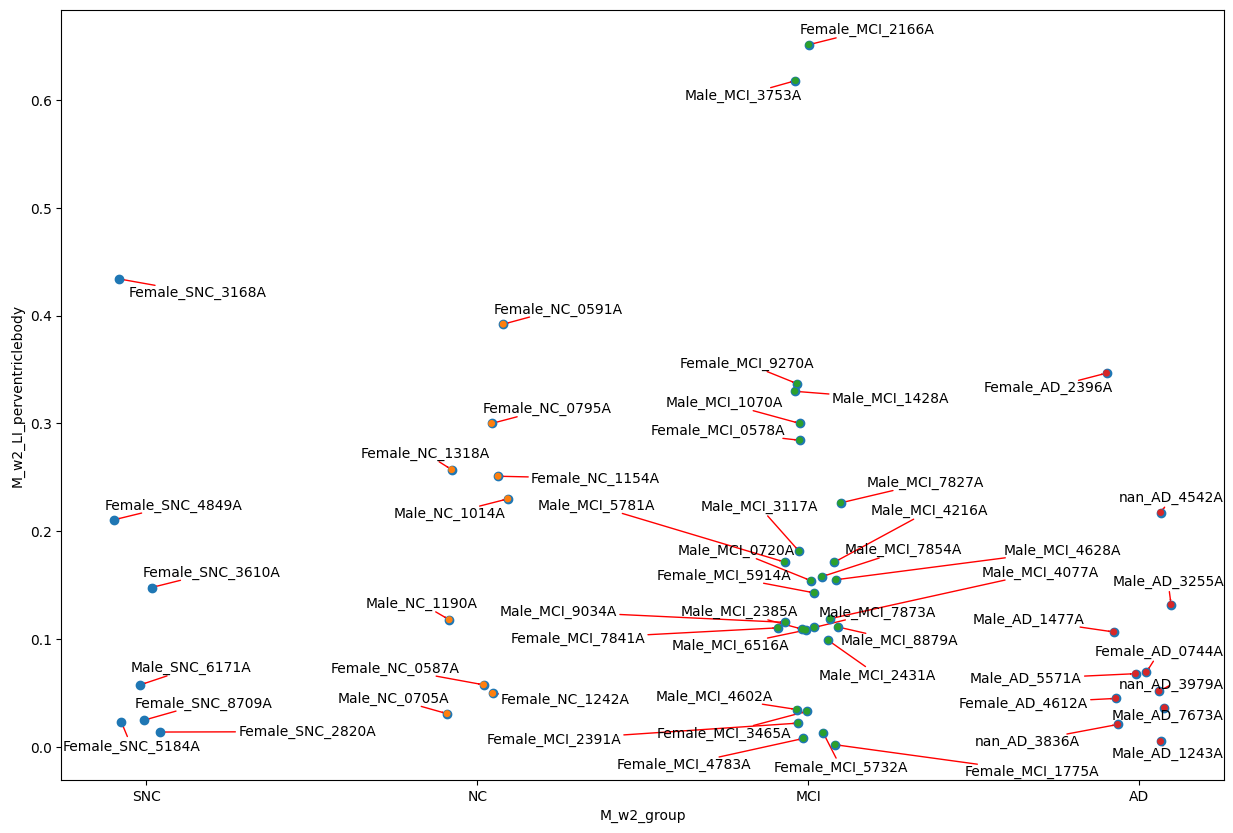

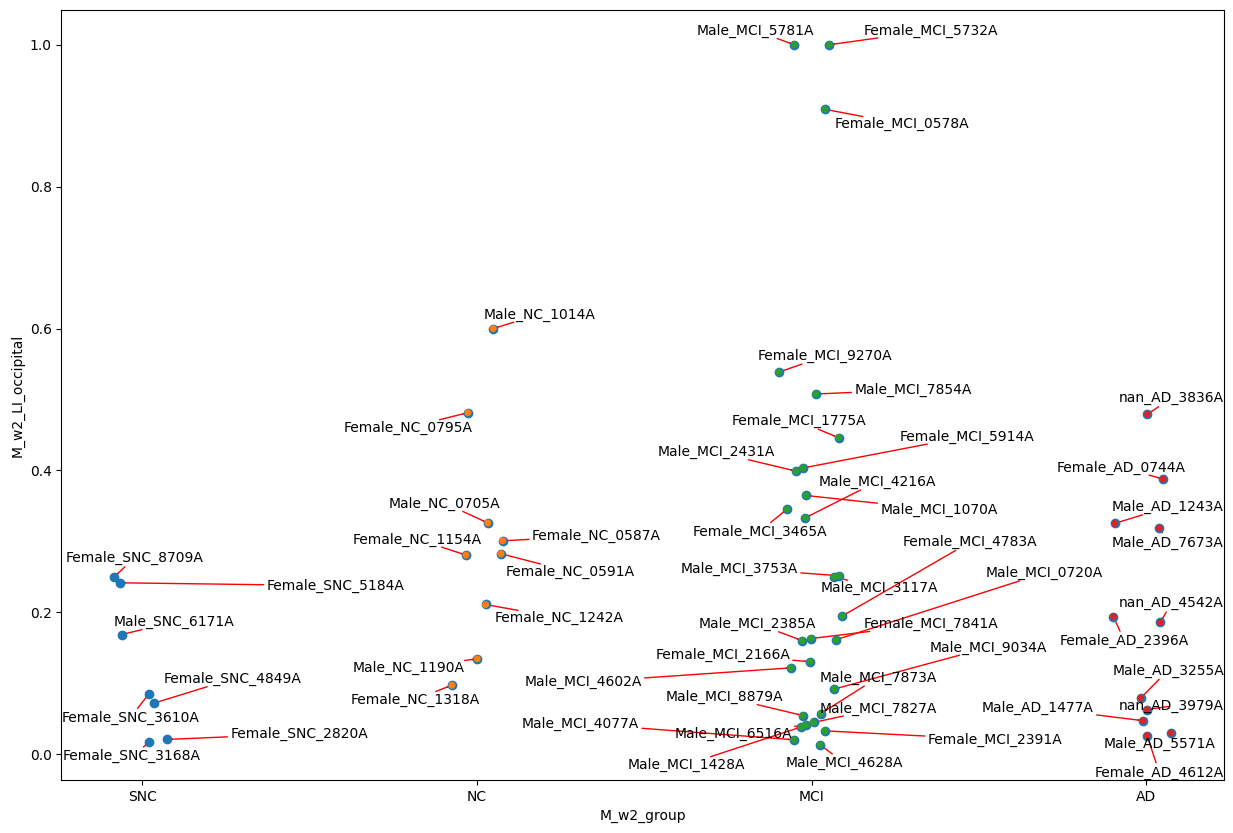

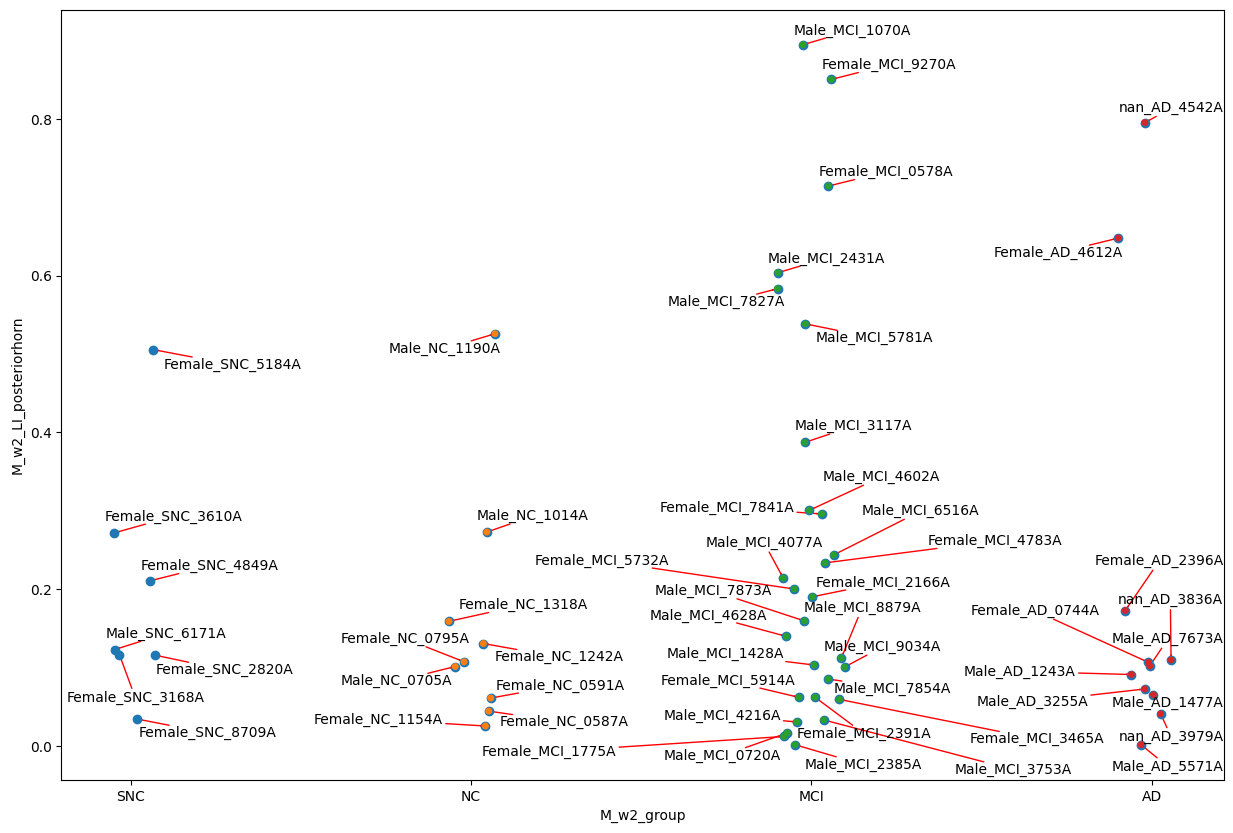

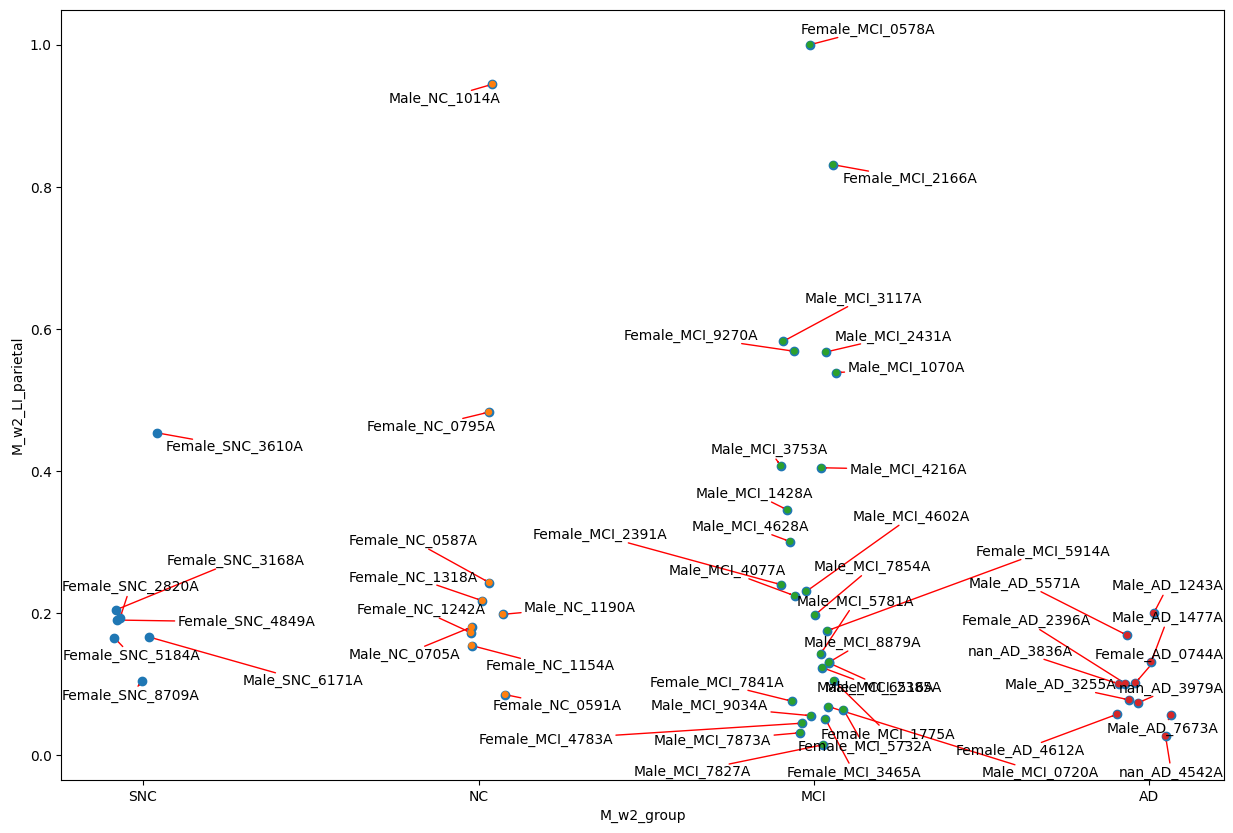

In [18]:
from adjustText import adjust_text
def stripplot_get_coordinates(data, x_var, y_var):
    # Demo dataset and apply some culling for visibility

    # Create the stripplot
    sns.stripplot(x=x_var, y=y_var, data=data, jitter=True, dodge=True, ax=ax)

    # Get the coordinates of the points
    coordinates = []
    for collection in ax.collections:
        coordinates.extend(collection.get_offsets())
    return np.array(coordinates)

for i in df.columns[23:]:
    figure = plt.figure(figsize=(15, 10))
    ax = figure.add_subplot(111)
    coordinates = stripplot_get_coordinates(df, 'M_w2_group', i)
    ax.plot(coordinates[:,0], coordinates[:,1], 'o')
    texts = [plt.text(coordinates[:,0][i], coordinates[:,1][i], f'{sex}_{group}_{caseid}', ha='center', va='center') for i, (group, caseid, sex) in enumerate(zip(df['M_w2_group'], df['M_w2_ID'], df['M_w2_sex']))]
    adjust_text(texts, expand=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='->', color='red') # ensure the labeling is clear by adding arrows
            )
    plt.show()